<a href="https://colab.research.google.com/github/Junghwan-brian/Dual_Stage_Attention_RNN/blob/master/colab_%EB%B0%94%EB%8B%A4%EB%82%98%EC%9A%B0%EC%96%B4%ED%85%90%EC%85%98%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Nov 12 02:00:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# imdb
from tensorflow.keras.datasets import imdb # 영화 리뷰 감성 분석 데이터셋. 긍정:1, 부정:0
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences # nlp, 다른 문장 길이 -> shape을 맞추기 위해서 사용합니다. 10,20,30 -> 20
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")
tf.random.set_seed(0)
tf.__version__

'2.3.0'

## 바다나우 어텐션

### imdb 데이터 불러오기

In [ ]:
num_words = 1000
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=num_words)
seq_lens = [len(data) for data in x_train]

17465344/17464789 [==============================] - 0s 0us/step


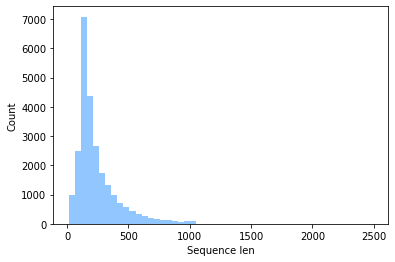

In [ ]:
plt.style.use("seaborn-pastel")
plt.hist(seq_lens,bins = 50)
plt.xlabel("Sequence len")
plt.ylabel("Count")
plt.show()

In [ ]:
max_len = 500
x_train = pad_sequences(x_train,maxlen=max_len, padding='pre')
x_test = pad_sequences(x_test,maxlen=max_len, padding='pre')

In [ ]:
x_train.shape, x_test.shape

((25000, 500), (25000, 500))

In [ ]:
x_train[0] # 데이터가 tokenize 되어 있다.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(128)

In [ ]:
a,b = next(iter(train_ds))

In [ ]:
a.shape, b.shape

(TensorShape([128, 500]), TensorShape([128]))

### 모델구현

어텐션 레이어 정의

In [ ]:
class bahdanau(Layer):
    def __init__(self,units):
        super(bahdanau,self).__init__()
        self.w1 = Dense(units)
        self.w2 = Dense(units)
        self.v = Dense(1)
    def call(self, query, values):
        '''
        query : batch_size, lstm_features
        values(==key) : batch_size, max_length, lstm_features
        '''
        query = tf.expand_dims(query,axis=1) # batch,1,lstm_features
        score = tf.nn.tanh(self.w1(values) + self.w2(query)) # batch(128), max_length(500), units(128)
        score = self.v(score) # batch,max_length,1

        attention_weights = tf.nn.softmax(score) # batch, max_len, 1 -> sequence에서 각 단어가 가지는 중요도!

        attention_value = attention_weights * values # batch, max_len, lstm_features
        # axis=1 -> 각 단어별 특징 값을 더한다는 뜻! -> 문장 하나당 1개의 감정분석을 낼 수 있다.
        attention_value = tf.reduce_sum(attention_value, axis=1)
        return attention_value, attention_weights

class Model(tf.keras.models.Model):
    def __init__(self):
        super(Model,self).__init__()
        self.embedding = Embedding(num_words, 128, input_length=max_len)
        self.lstm = LSTM(128, return_sequences=True, return_state = True) # 전체 타임 스텝의 hidden state를 받고, cell state도 받겠다.
        self.attention = bahdanau(128)
        self.dropout = Dropout(0.3)
        self.dense1 = Dense(30, activation = 'relu')
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        embedding = self.embedding(x) # batch, 500, 128
        lstm_h, h, c = self.lstm(embedding) # (batch, 500, 128), (batch, 128)
        h = tf.concat([h,c], axis=-1) # batch, 256
        attention_v, attention_w = self.attention(h,lstm_h)
        hidden = self.dropout(attention_v, training = training)
        hidden = self.dense1(hidden)
        output = self.dense2(hidden)
        return output

In [ ]:
model = Model()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(train_ds, epochs = 3, validation_data = test_ds, verbose = 1)

Epoch 1/3
196/196 [==============================] - 16s 80ms/step - loss: 0.7475 - accuracy: 0.5300 - val_loss: 0.7829 - val_accuracy: 0.5771
Epoch 2/3
196/196 [==============================] - 15s 78ms/step - loss: 0.4577 - accuracy: 0.7815 - val_loss: 0.3882 - val_accuracy: 0.8253
Epoch 3/3
196/196 [==============================] - 15s 79ms/step - loss: 0.3378 - accuracy: 0.8557 - val_loss: 0.3633 - val_accuracy: 0.8378
